<a href="https://colab.research.google.com/github/ziatdinovmax/gpax/blob/main/examples/compare_GPs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Compare ExactGP and viGP

This is a simple notebook to compare timings and results of two different commonly used GPs. One trained using HMC/NUTS, and the other trained using SVI.

*Prepared by Matthew R. Carbone & Maxim Ziatdinov (2023). Last updated in November 2023.*

## Background

Depending on the amount of data you have, the number of dimensions the inputs have, and your time budget for training, you may want to use a GP fit using stochastic variational inference vs. Markov chain monte carlo. The following compares some strengths and weaknesses of the two methods.

**Hamiltonian Monte Carlo (HMC)/No U-Turn Sampler (NUTS)**

- Sensitivity to Priors: This can be perceived as a strength or a weakness, depending on the context. However, many researchers appreciate it because it offers a more intuitive grasp of the model.
- Reliable Uncertainty Estimates: Offers robust evaluations of uncertainties as it directly samples from the posterior. The variational methods are known to lead to underestimation of uncertainties.
- Integration with Classical Bayesian Models: This is particularly evident when you consider the combination of Gaussian Processes with traditional Bayesian models, as demonstrated in structured GP and hypothesis learning.
- Comprehensive Convergence Diagnostics: Indicators such as n_eff, r_hat, and acc_prob for each inferred parameter.
- Speed Limitations: One of the primary drawbacks is its computational speed.

**Stochastic Variational Inference (SVI)**

- Efficiency: It's significantly faster and is memory-efficient (performs equally well with 32-bit precision)
- Acceptable Trade-offs: For many real-world tasks, the slight decrease in the accuracy of predictive uncertainty estimates is either negligible or acceptable.
- Convergence Indicator Limitations: The loss may not be a very good indicator of convergence - can easily overshoot or undershoot.

## Install & Import

Install the latest GPax package from PyPI (this is best practice, as it installs the latest, deployed and tested version). Please do not install from a GitHub url!

In [1]:
!pip install gpax

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.4/83.4 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.7/312.7 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 371.0/371.0 kB 9.4 MB/s eta 0:00:00


Import needed packages:

In [2]:
try:
    # For use on Google Colab
    import gpax

except ImportError:
    # For use locally (where you're using the local version of gpax)
    print("Assuming notebook is being run locally, attempting to import local gpax module")
    import sys
    sys.path.append("..")
    import gpax

In [3]:
import numpy as np
import matplotlib.pyplot as plt

gpax.utils.enable_x64()  # enable double precision

Enable some pretty plotting.

In [4]:
import matplotlib as mpl

In [5]:
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['text.usetex'] = False
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)
mpl.rcParams['figure.dpi'] = 200

## Create data

Generate some noisy observations:

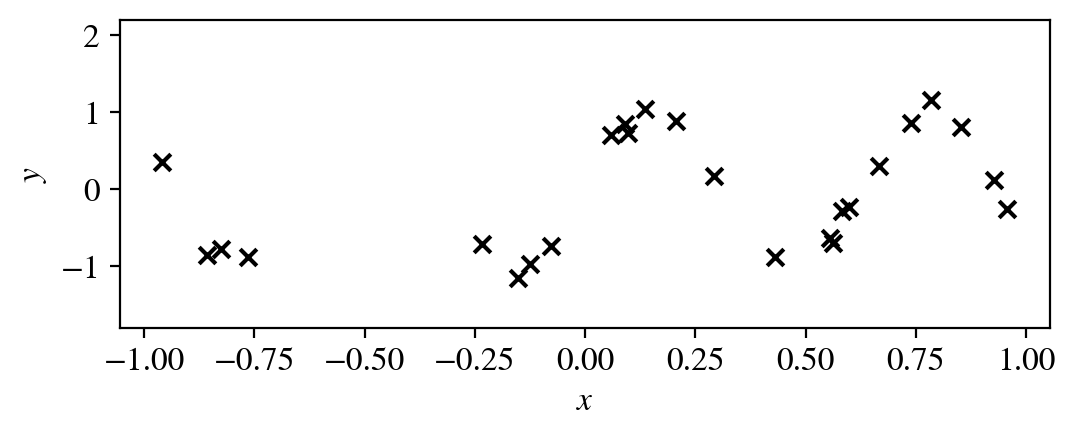

In [6]:
np.random.seed(0)

NUM_INIT_POINTS = 25 # number of observation points
NOISE_LEVEL = 0.1 # noise level

# Generate noisy data from a known function
f = lambda x: np.sin(10*x)

X = np.random.uniform(-1., 1., NUM_INIT_POINTS)
y = f(X) + np.random.normal(0., NOISE_LEVEL, NUM_INIT_POINTS)

# Plot generated data
fig, ax = plt.subplots(1, 1, figsize=(6, 2))
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.scatter(X, y, marker='x', c='k', zorder=1, label='Noisy observations')
ax.set_ylim(-1.8, 2.2)
plt.show()

## Standard `ExactGP`

Next, we initialize and train a GP model. We are going to use an RBF kernel, $k_{RBF}=𝜎exp(-\frac{||x_i-x_j||^2}{2l^2})$, which is a "go-to" kernel functions in GP.

In [7]:
# Get random number generator keys for training and prediction
rng_key, rng_key_predict = gpax.utils.get_keys()

# Initialize model
gp_model_1 = gpax.ExactGP(1, kernel='RBF')

# Run Hamiltonian Monte Carlo to obtain posterior samples for kernel parameters and model noise
gp_model_1.fit(rng_key, X, y, num_chains=1)

sample: 100%|██████████| 4000/4000 [00:12<00:00, 311.63it/s, 7 steps of size 5.52e-01. acc. prob=0.90] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.17      0.03      0.17      0.12      0.23   1017.15      1.00
    k_scale      1.25      0.90      0.99      0.29      2.33    850.74      1.00
      noise      0.03      0.02      0.03      0.01      0.06   1039.66      1.00



## Standard `viGP`

In [8]:
# Get random number generator keys for training and prediction
rng_key, rng_key_predict = gpax.utils.get_keys()

# Initialize model
gp_model_2 = gpax.viGP(1, kernel='RBF')

# Run Hamiltonian Monte Carlo to obtain posterior samples for kernel parameters and model noise
gp_model_2.fit(rng_key, X, y)

100%|██████████| 1000/1000 [00:01<00:00, 657.22it/s, init loss: 33.8362, avg. loss [951-1000]: 11.9065]



Inferred GP parameters
k_length         [0.1487]
k_scale          0.6521
noise            0.024


In [9]:
X_test = np.linspace(-1, 1, 100)

In [10]:
y_pred_1, y_sampled_1 = gp_model_1.predict(rng_key_predict, X_test, n=200)

In [11]:
y_pred_2, y_sampled_2 = gp_model_2.predict(rng_key_predict, X_test, n=200)

Note that SVI (the `viGP`) is significantly faster (use the `% timeit` magic before the command to see). SVI is usually better to use on larger datasets and is more easily scalable. In this case, they produce similar results.

In [12]:
y_sampled_1.shape

(2000, 200, 100)

In [13]:
y_sampled_2.shape  # Note shape difference between predict methods

(100,)

Plot the obtained results:

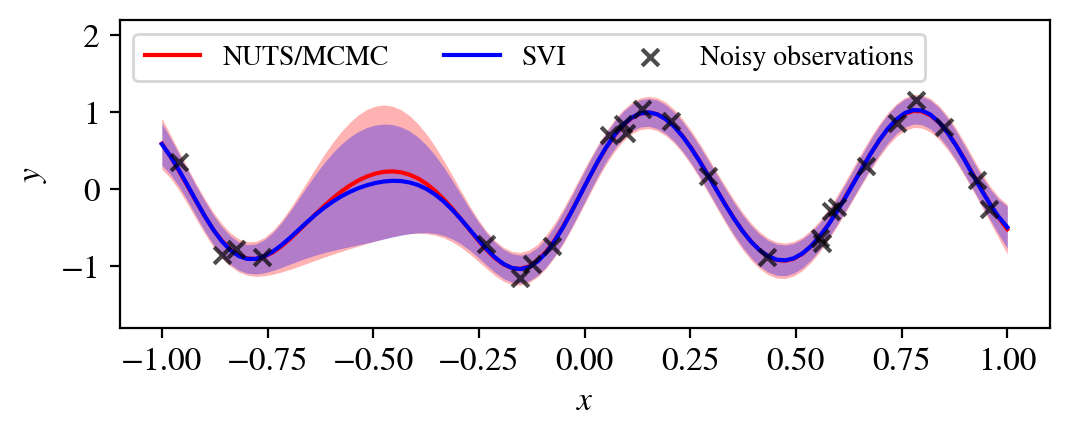

In [14]:
_, ax = plt.subplots(1, 1, figsize=(6, 2))

ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.plot(X_test, y_pred_1, lw=1.5, zorder=2, c='r', label='NUTS/MCMC')
ax.fill_between(X_test, y_pred_1 - y_sampled_1.std(axis=(0,1)), y_pred_1 + y_sampled_1.std(axis=(0,1)),
                color='r', alpha=0.3, linewidth=0)


ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.plot(X_test, y_pred_2, lw=1.5, zorder=2, c='b', label='SVI')
ax.fill_between(X_test, y_pred_2 - np.sqrt(y_sampled_2), y_pred_2 + np.sqrt(y_sampled_2),
                color='b', alpha=0.3, linewidth=0)



ax.set_ylim(-1.8, 2.2)

ax.scatter(X, y, marker='x', c='k', zorder=2, label="Noisy observations", alpha=0.7)

ax.legend(loc='upper left', ncols=3)

plt.show()